# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [6]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set_style('darkgrid')

In [2]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

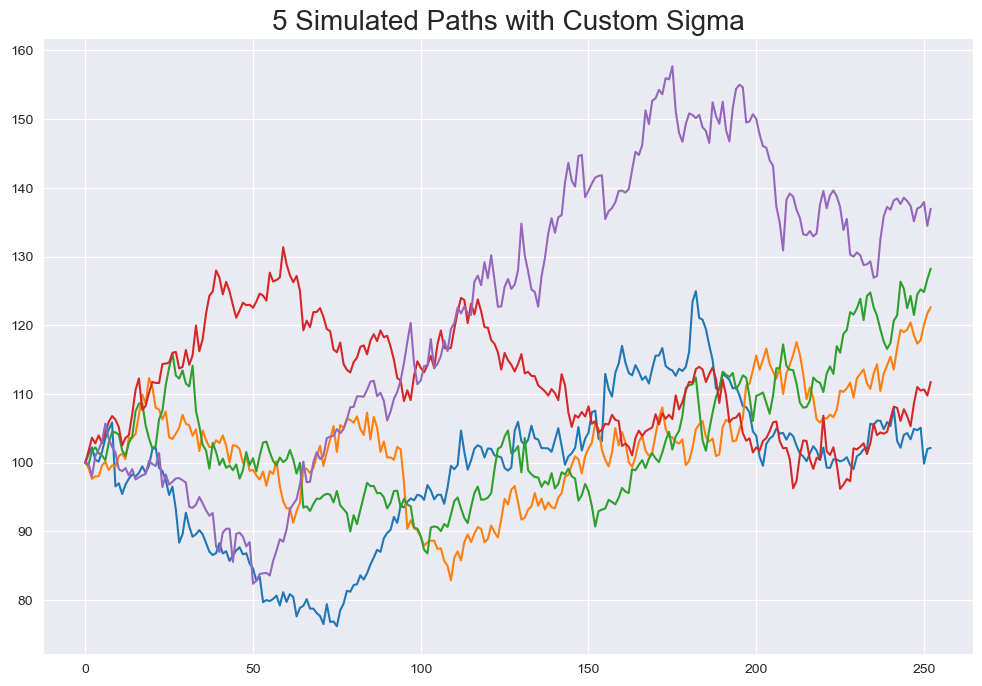

In [3]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

In [4]:
# Black-Scholes delta for call option
def delta_call(S, K, sigma, t, r=0.0):
    if t == 0 or sigma == 0:
        return 1.0 if S > K else 0.0
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*t) / (sigma * np.sqrt(t))
    return norm.cdf(d1)

# Black-Scholes price for call option
def bs_call(S, K, sigma, t, r=0.0):
    if t == 0 or sigma == 0:
        return max(S - K, 0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    return S * norm.cdf(d1) - K * np.exp(-r*t) * norm.cdf(d2)

# Simulate stock paths with time-varying sigma
def simulate_paths(S0, mu, r, T, N, n_paths):
    dt = T / N
    all_paths = []
    all_sigmas = []

    for _ in range(n_paths):
        S = [S0]
        sigmas = []
        for _ in range(N):
            sigma = np.random.choice([0.2, 0.3, 0.45], p=[0.5, 0.3, 0.2])
            sigmas.append(sigma)
            dW = np.random.normal(0, np.sqrt(dt))
            dS = (mu - 0.5 * sigma**2) * dt + sigma * dW
            S.append(S[-1] * np.exp(dS))
        all_paths.append(S)
        all_sigmas.append(sigmas)
    return np.array(all_paths), np.array(all_sigmas)

# Hedging strategy
def delta_hedge_profit(paths, sigmas, K, r, T):
    N = paths.shape[1] - 1
    dt = T / N
    profits = []

    for path, sigma_path in zip(paths, sigmas):
        S_path = path
        cash = 0.0
        shares = 0.0

        for i in range(N):
            S = S_path[i]
            sigma = sigma_path[i]
            t = T - i*dt
            delta = delta_call(S, K, sigma, t, r)
            d_shares = delta - shares

            # Update cash position
            cash -= d_shares * S
            cash *= np.exp(r*dt)
            shares = delta

        final_val = shares * S_path[-1] + cash
        option_price_0 = bs_call(S_path[0], K, sigma_path[0], T, r)
        profit = final_val - option_price_0
        profits.append(profit)

    return profits

count    100.000000
mean     -14.300615
std       21.514726
min      -36.552597
25%      -26.105562
50%      -22.085489
75%       -9.102478
max      103.148736
dtype: float64


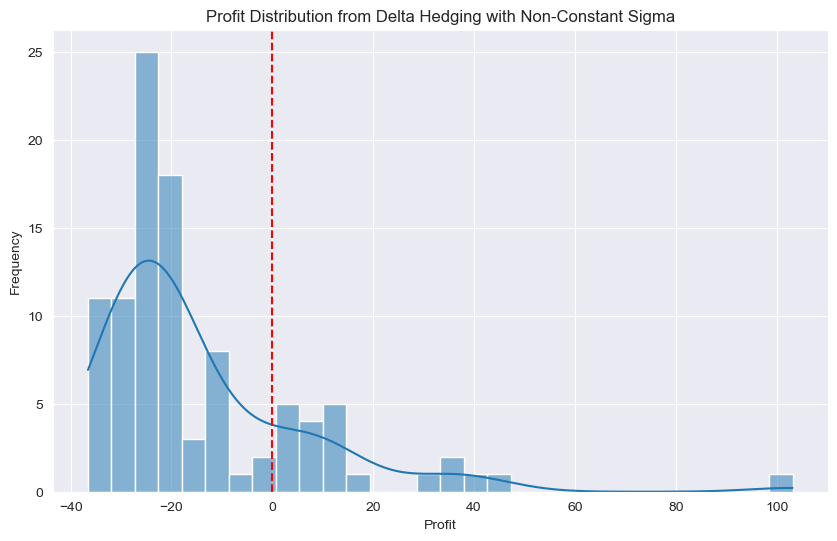

In [7]:
# Parameters
S0 = 100
K = 100
mu = 0.1
r = 0.02
T = 1  # 1 year
N = 252  # Daily steps
n_paths = 100

# Simulate
paths, sigmas = simulate_paths(S0, mu, r, T, N, n_paths)
profits = delta_hedge_profit(paths, sigmas, K, r, T)

# Summary stats
profits_series = pd.Series(profits)
print(profits_series.describe())

# Plot profit distribution
plt.figure(figsize=(10,6))
sns.histplot(profits_series, bins=30, kde=True)
plt.title("Profit Distribution from Delta Hedging with Non-Constant Sigma")
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.show()